In [1]:
import wfdb
import os
import pandas as pd

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"

# 获取所有记录名称（去掉扩展名）
record_files = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.dat')]
record_files = sorted(list(set(record_files)))  # 去重并排序

# 存储数据的字典
data = []

# 遍历每个记录
for record_name in record_files:
    try:
        record_path = os.path.join(data_dir, record_name)
        # 读取信号
        record = wfdb.rdrecord(record_path, channels=[0])
        signals = record.p_signal
        fs = record.fs
        # 读取注释
        annotation = wfdb.rdann(record_path, 'atr')
        annotation_times = annotation.sample
        annotation_symbols = annotation.symbol
        # 保存到字典
        data.append({
            'record_name': record_name,
            'signals': signals,
            'fs': fs,
            'annotation_times': annotation_times,
            'annotation_symbols': annotation_symbols
        })
        print(f"已加载记录 {record_name}: 信号形状 {signals.shape}, 注释数量 {len(annotation_times)}")
    except Exception as e:
        print(f"加载记录 {record_name} 失败: {e}")

# 保存数据概览到CSV（便于检查）
summary = pd.DataFrame([
    {
        'record_name': d['record_name'],
        'signal_length': d['signals'].shape[0],
        'num_annotations': len(d['annotation_times'])
    } for d in data
])
summary.to_csv("~/Downloads/data/ECG/data_summary.csv", index=False)
print("数据概览已保存到 data_summary.csv")

已加载记录 100: 信号形状 (650000, 1), 注释数量 2274
已加载记录 101: 信号形状 (650000, 1), 注释数量 1874
已加载记录 102: 信号形状 (650000, 1), 注释数量 2192
已加载记录 103: 信号形状 (650000, 1), 注释数量 2091
已加载记录 104: 信号形状 (650000, 1), 注释数量 2311
已加载记录 105: 信号形状 (650000, 1), 注释数量 2691
已加载记录 106: 信号形状 (650000, 1), 注释数量 2098
已加载记录 107: 信号形状 (650000, 1), 注释数量 2140
已加载记录 108: 信号形状 (650000, 1), 注释数量 1824
已加载记录 109: 信号形状 (650000, 1), 注释数量 2535
已加载记录 111: 信号形状 (650000, 1), 注释数量 2133
已加载记录 112: 信号形状 (650000, 1), 注释数量 2550
已加载记录 113: 信号形状 (650000, 1), 注释数量 1796
已加载记录 114: 信号形状 (650000, 1), 注释数量 1890
已加载记录 115: 信号形状 (650000, 1), 注释数量 1962
已加载记录 116: 信号形状 (650000, 1), 注释数量 2421
已加载记录 117: 信号形状 (650000, 1), 注释数量 1539
已加载记录 118: 信号形状 (650000, 1), 注释数量 2301
已加载记录 119: 信号形状 (650000, 1), 注释数量 2094
已加载记录 121: 信号形状 (650000, 1), 注释数量 1876
已加载记录 122: 信号形状 (650000, 1), 注释数量 2479
已加载记录 123: 信号形状 (650000, 1), 注释数量 1519
已加载记录 124: 信号形状 (650000, 1), 注释数量 1634
已加载记录 200: 信号形状 (650000, 1), 注释数量 2792
已加载记录 201: 信号形状 (650000, 1), 注释数量 2039
已加载记录 202: 信号形状 (650000, 

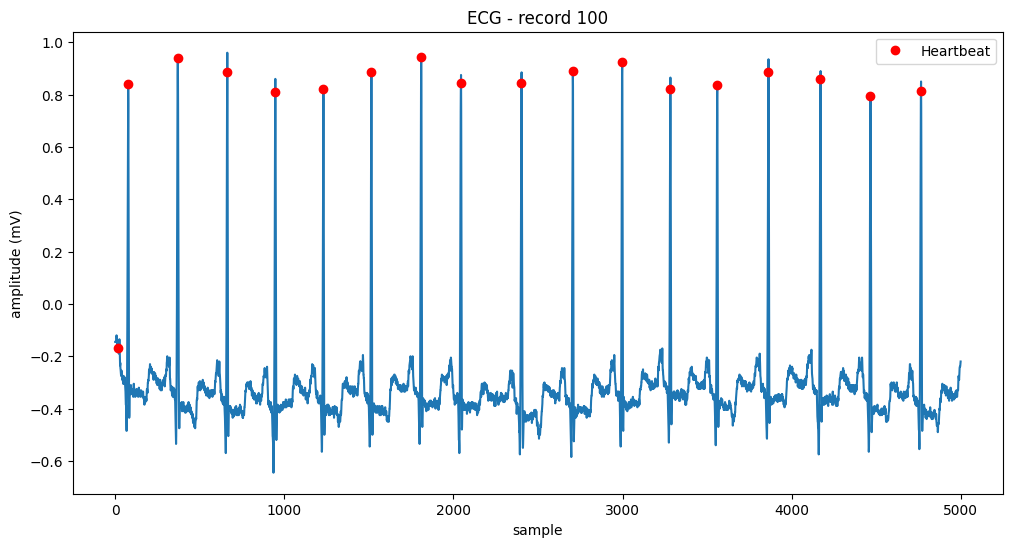

In [2]:
import matplotlib.pyplot as plt
import wfdb
import os

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
record_name = "100"

# 验证路径是否存在
record_path = os.path.join(data_dir, record_name)
if not os.path.exists(record_path + ".dat"):
    raise FileNotFoundError(f"file {record_path}.dat not exist")

# 加载数据
record = wfdb.rdrecord(record_path, channels=[0])  # 读取第一个通道（MLII）
signals = record.p_signal
annotation = wfdb.rdann(record_path, 'atr')
annotation_times = annotation.sample
annotation_symbols = annotation.symbol

# 绘制前5000个样本（约14秒）
start, end = 0, 5000
plt.figure(figsize=(12, 6))
plt.plot(signals[start:end])
valid_annotations = (annotation_times >= start) & (annotation_times < end)
plt.plot(annotation_times[valid_annotations] - start,
        signals[annotation_times[valid_annotations]], "ro", label="Heartbeat")
plt.title(f"ECG - record {record_name}")
plt.xlabel("sample")
plt.ylabel("amplitude (mV)")
plt.legend()

# 保存图像到指定路径
output_path = os.path.expanduser("~/Downloads/data/ECG")
os.makedirs(output_path, exist_ok=True)
plt.savefig(os.path.join(output_path, f"ecg_{record_name}.png"))
plt.show()

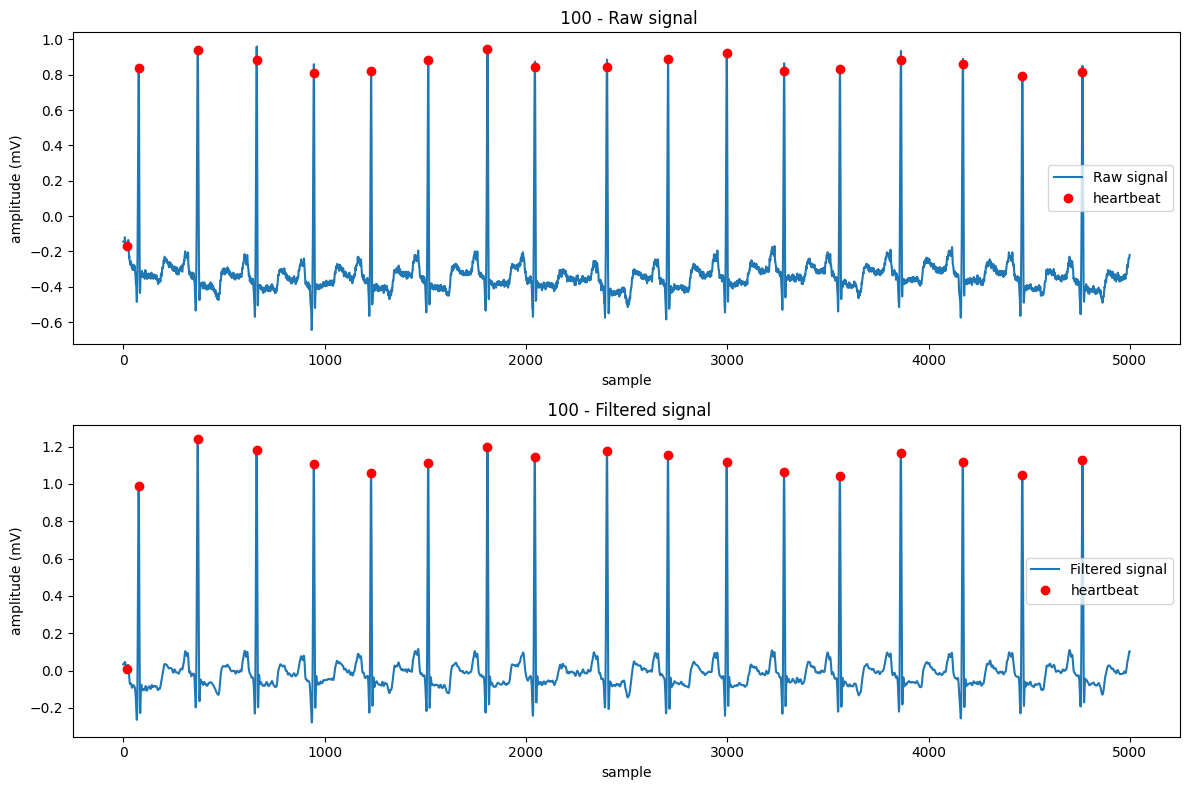

In [3]:
import wfdb
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# 确保Jupyter Lab直接显示图形
# %matplotlib inline  # 如果直接在Jupyter Lab运行，取消注释此行

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
record_name = "100"
record_path = os.path.join(data_dir, record_name)

# 验证路径
if not os.path.exists(record_path + ".dat"):
    raise FileNotFoundError(f"数据文件 {record_path}.dat 不存在，请检查路径或文件完整性")

# 加载信号和注释
record = wfdb.rdrecord(record_path, channels=[0])  # 第一个通道（MLII）
signals = record.p_signal.flatten()  # 转换为1D数组
fs = record.fs  # 采样频率（360Hz）
annotation = wfdb.rdann(record_path, 'atr')
annotation_times = annotation.sample
annotation_symbols = annotation.symbol

# 带通滤波
lowcut = 0.5  # 低频截止（去除基线漂移）
highcut = 40.0  # 高频截止（去除肌肉伪影）
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # 4阶巴特沃斯滤波器
filtered_signals = signal.filtfilt(b, a, signals)  # 双向滤波

# 可视化原始信号与滤波信号
start, end = 0, 5000  # 前5000个样本（约14秒）
plt.figure(figsize=(12, 8))

# 原始信号
plt.subplot(2, 1, 1)
plt.plot(signals[start:end], label='Raw signal')
valid_annotations = (annotation_times >= start) & (annotation_times < end)
plt.plot(annotation_times[valid_annotations] - start,
         signals[annotation_times[valid_annotations]], 'ro', label='heartbeat')
plt.title(f' {record_name} - Raw signal')
plt.xlabel('sample')
plt.ylabel('amplitude (mV)')
plt.legend()

# 滤波信号
plt.subplot(2, 1, 2)
plt.plot(filtered_signals[start:end], label='Filtered signal')
plt.plot(annotation_times[valid_annotations] - start,
         filtered_signals[annotation_times[valid_annotations]], 'ro', label='heartbeat')
plt.title(f' {record_name} - Filtered signal')
plt.xlabel('sample')
plt.ylabel('amplitude (mV)')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import wfdb
import os
import numpy as np
from scipy import signal
import pandas as pd

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
output_dir = "/Users/mac/Downloads/data/ECG/processed"
os.makedirs(output_dir, exist_ok=True)

# 获取所有记录
record_files = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.dat')]
record_files = sorted(list(set(record_files)))

# 带通滤波函数
def preprocess_signal(signals, fs, lowcut=0.5, highcut=40.0):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, signals)

# 批量处理
data_summary = []
for record_name in record_files:
    try:
        record_path = os.path.join(data_dir, record_name)
        record = wfdb.rdrecord(record_path, channels=[0])
        signals = record.p_signal.flatten()
        fs = record.fs
        annotation = wfdb.rdann(record_path, 'atr')

        # 滤波
        filtered_signals = preprocess_signal(signals, fs)

        # 保存滤波信号
        np.save(os.path.join(output_dir, f"{record_name}_filtered.npy"), filtered_signals)

        # 记录概览
        data_summary.append({
            'record_name': record_name,
            'signal_length': len(signals),
            'num_annotations': len(annotation.sample)
        })
        print(f"已处理记录 {record_name}")
    except Exception as e:
        print(f"处理记录 {record_name} 失败: {e}")

# 保存概览
pd.DataFrame(data_summary).to_csv(os.path.join(output_dir, "data_summary.csv"), index=False)
print("预处理完成，概览保存到 data_summary.csv")

已处理记录 100
已处理记录 101
已处理记录 102
已处理记录 103
已处理记录 104
已处理记录 105
已处理记录 106
已处理记录 107
已处理记录 108
已处理记录 109
已处理记录 111
已处理记录 112
已处理记录 113
已处理记录 114
已处理记录 115
已处理记录 116
已处理记录 117
已处理记录 118
已处理记录 119
已处理记录 121
已处理记录 122
已处理记录 123
已处理记录 124
已处理记录 200
已处理记录 201
已处理记录 202
已处理记录 203
已处理记录 205
已处理记录 207
已处理记录 208
已处理记录 209
已处理记录 210
已处理记录 212
已处理记录 213
已处理记录 214
已处理记录 215
已处理记录 217
已处理记录 219
已处理记录 220
已处理记录 221
已处理记录 222
已处理记录 223
已处理记录 228
已处理记录 230
已处理记录 231
已处理记录 232
已处理记录 233
已处理记录 234
预处理完成，概览保存到 data_summary.csv


R波是ECG信号中QRS复合波的最高峰，对应心跳的发生。检测R波的目的是：

定位心跳：确定每次心跳的时间点（样本索引）。
计算RR间隔：相邻R波之间的时间间隔，用于心率变异性（HRV）分析。
特征提取：RR间隔和其他HRV指标是机器学习分类的关键特征。
R波检测方法
R波通常具有高幅度和陡峭的上升/下降特征，易于检测。我们选择简单、有效的峰值检测方法：

使用scipy.signal.find_peaks识别信号中的高峰。
在预处理后的信号上操作，确保噪声较少，R波更突出。
验证检测结果与MIT-BIH的注释（.atr文件）一致。

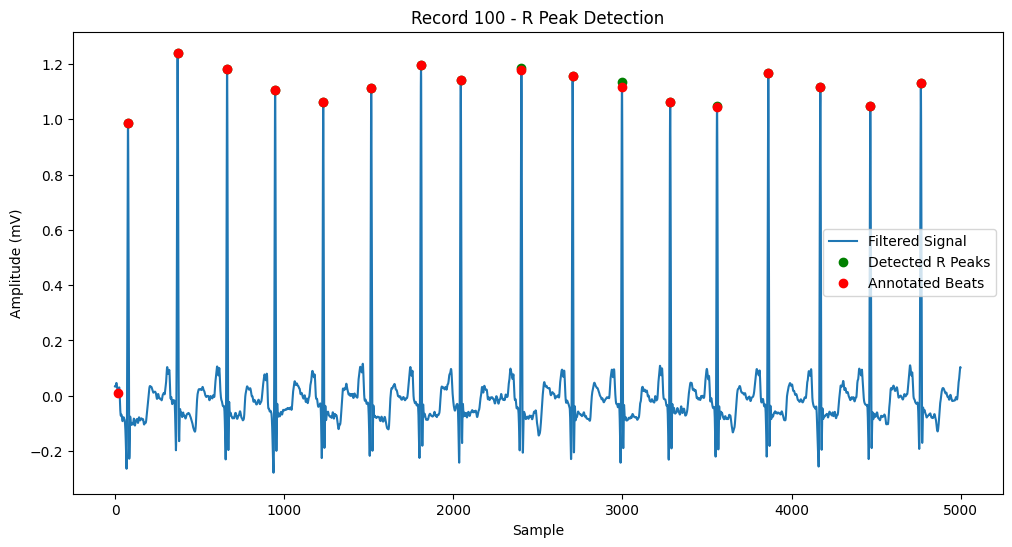

Detected 2285 R peaks
RR Intervals (seconds): Mean=0.790, Std=0.067


In [5]:
import wfdb
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# 确保Jupyter Lab直接显示图形
# %matplotlib inline  # 如果在Jupyter Lab运行，取消注释此行

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
record_name = "100"
record_path = os.path.join(data_dir, record_name)

# 验证路径是否存在
if not os.path.exists(record_path + ".dat"):
    raise FileNotFoundError(f"Data file {record_path}.dat not found, please check path or file integrity")

# 加载信号和注释
record = wfdb.rdrecord(record_path, channels=[0])  # 第一个通道（MLII）
signals = record.p_signal.flatten()  # 转换为1D数组
fs = record.fs  # 采样频率（360Hz）
annotation = wfdb.rdann(record_path, 'atr')
annotation_times = annotation.sample
annotation_symbols = annotation.symbol

# 应用带通滤波
lowcut = 0.5
highcut = 40.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')
filtered_signals = signal.filtfilt(b, a, signals)

# 检测R波
min_distance = int(0.2 * fs)  # 最小R波间隔（0.2秒）
peaks, _ = signal.find_peaks(filtered_signals, distance=min_distance, height=np.mean(filtered_signals) + 0.5 * np.std(filtered_signals))
rr_intervals = np.diff(peaks) / fs  # RR间隔（秒）

# 可视化R波检测结果 显示滤波信号，绿色圆点为检测的R波，红色圆点为注释心跳
start, end = 0, 5000  # 前5000个样本（约14秒）
plt.figure(figsize=(12, 6))
plt.plot(filtered_signals[start:end], label='Filtered Signal')
valid_peaks = (peaks >= start) & (peaks < end)
plt.plot(peaks[valid_peaks] - start, filtered_signals[peaks[valid_peaks]], 'go', label='Detected R Peaks')
valid_annotations = (annotation_times >= start) & (annotation_times < end)
plt.plot(annotation_times[valid_annotations] - start, filtered_signals[annotation_times[valid_annotations]], 'ro', label='Annotated Beats')
plt.title(f'Record {record_name} - R Peak Detection')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.show()

# 打印RR间隔统计
print(f"Detected {len(peaks)} R peaks")
print(f"RR Intervals (seconds): Mean={np.mean(rr_intervals):.3f}, Std={np.std(rr_intervals):.3f}")

In [6]:
import wfdb
import os
import numpy as np
from scipy import signal
import pandas as pd

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
output_dir = "/Users/mac/Downloads/data/ECG/processed"
os.makedirs(output_dir, exist_ok=True)

# 获取所有记录
record_files = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.dat')]
record_files = sorted(list(set(record_files)))

# 带通滤波函数
def preprocess_signal(signals, fs, lowcut=0.5, highcut=40.0):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, signals)

# R波检测函数
def detect_r_peaks(signals, fs):
    min_distance = int(0.2 * fs)
    peaks, _ = signal.find_peaks(signals, distance=min_distance, height=np.mean(signals) + 0.5 * np.std(signals))
    rr_intervals = np.diff(peaks) / fs
    return peaks, rr_intervals

# 批量处理
data_summary = []
for record_name in record_files:
    try:
        record_path = os.path.join(data_dir, record_name)
        record = wfdb.rdrecord(record_path, channels=[0])
        signals = record.p_signal.flatten()
        fs = record.fs
        annotation = wfdb.rdann(record_path, 'atr')

        # 滤波
        filtered_signals = preprocess_signal(signals, fs)

        # R波检测
        peaks, rr_intervals = detect_r_peaks(filtered_signals, fs)

        # 保存结果
        np.save(os.path.join(output_dir, f"{record_name}_peaks.npy"), peaks)
        np.save(os.path.join(output_dir, f"{record_name}_rr_intervals.npy"), rr_intervals)

        # 记录概览
        data_summary.append({
            'record_name': record_name,
            'num_peaks': len(peaks),
            'rr_mean': np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan,
            'rr_std': np.std(rr_intervals) if len(rr_intervals) > 0 else np.nan
        })
        print(f"Processed record {record_name}: {len(peaks)} R peaks")
    except Exception as e:
        print(f"Failed to process record {record_name}: {e}")

# 保存概览
pd.DataFrame(data_summary).to_csv(os.path.join(output_dir, "r_peak_summary.csv"), index=False)
print("R peak detection completed, summary saved to r_peak_summary.csv")

Processed record 100: 2285 R peaks
Processed record 101: 3658 R peaks
Processed record 102: 3550 R peaks
Processed record 103: 4157 R peaks
Processed record 104: 3807 R peaks
Processed record 105: 2929 R peaks
Processed record 106: 3691 R peaks
Processed record 107: 4211 R peaks
Processed record 108: 2825 R peaks
Processed record 109: 2685 R peaks
Processed record 111: 4278 R peaks
Processed record 112: 5071 R peaks
Processed record 113: 3583 R peaks
Processed record 114: 3402 R peaks
Processed record 115: 3355 R peaks
Processed record 116: 3980 R peaks
Processed record 117: 3072 R peaks
Processed record 118: 4192 R peaks
Processed record 119: 3495 R peaks
Processed record 121: 3451 R peaks
Processed record 122: 2477 R peaks
Processed record 123: 3286 R peaks
Processed record 124: 1640 R peaks
Processed record 200: 3258 R peaks
Processed record 201: 3190 R peaks
Processed record 202: 3198 R peaks
Processed record 203: 3351 R peaks
Processed record 205: 3610 R peaks
Processed record 207

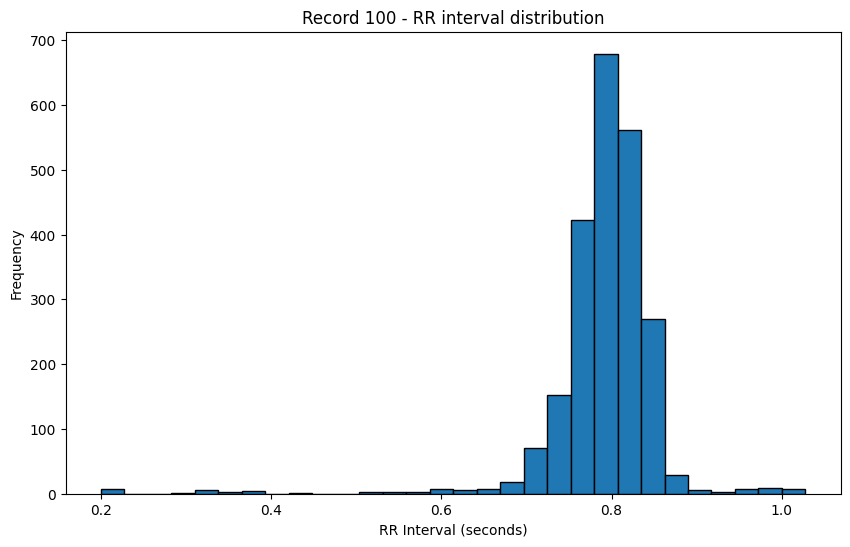

HRV Features for Record 100:
sdnn: 0.0673
rmssd: 0.0786
pnn50: 0.1117
mean_rr: 0.7904


In [7]:
import wfdb
import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd

# 确保Jupyter Lab直接显示图形
# %matplotlib inline  # 如果在Jupyter Lab运行，取消注释此行

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
output_dir = "/Users/mac/Downloads/data/ECG/processed"
record_name = "100"
record_path = os.path.join(data_dir, record_name)
os.makedirs(output_dir, exist_ok=True)

# 验证路径
if not os.path.exists(record_path + ".dat"):
    raise FileNotFoundError(f"Data file {record_path}.dat not found, please check path or file integrity")

# 加载信号和注释
record = wfdb.rdrecord(record_path, channels=[0])
signals = record.p_signal.flatten()
fs = record.fs
annotation = wfdb.rdann(record_path, 'atr')
annotation_times = annotation.sample
annotation_symbols = annotation.symbol

# 带通滤波
lowcut = 0.5
highcut = 40.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')
filtered_signals = signal.filtfilt(b, a, signals)

# R波检测
min_distance = int(0.2 * fs)
peaks, _ = signal.find_peaks(filtered_signals, distance=min_distance, height=np.mean(filtered_signals) + 0.5 * np.std(filtered_signals))
rr_intervals = np.diff(peaks) / fs  # RR间隔（秒）

# 提取时域HRV特征
def extract_hrv_features(rr_intervals):
    sdnn = np.std(rr_intervals)  # RR间隔标准差
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # 相邻RR间隔差的均方根
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)  # 差值超过50ms的次数
    pnn50 = nn50 / len(np.diff(rr_intervals)) if len(np.diff(rr_intervals)) > 0 else 0  # 比例
    mean_rr = np.mean(rr_intervals)  # 平均RR间隔
    return {
        'sdnn': sdnn,
        'rmssd': rmssd,
        'pnn50': pnn50,
        'mean_rr': mean_rr
    }

hrv_features = extract_hrv_features(rr_intervals)

# 保存特征
features_df = pd.DataFrame([hrv_features])
features_df['record_name'] = record_name
features_df.to_csv(os.path.join(output_dir, f"hrv_features_{record_name}.csv"), index=False)

# 可视化RR间隔分布
plt.figure(figsize=(10, 6))
plt.hist(rr_intervals, bins=30, edgecolor='black')
plt.title(f'Record {record_name} - RR interval distribution')

plt.xlabel('RR Interval (seconds)')
plt.ylabel('Frequency')
plt.show()

# 打印特征
print(f"HRV Features for Record {record_name}:")
for key, value in hrv_features.items():
    print(f"{key}: {value:.4f}")

峰值处于0.8-1之间，正常。

In [8]:
import wfdb
import os
import numpy as np
from scipy import signal
import pandas as pd

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
output_dir = "/Users/mac/Downloads/data/ECG/processed"
os.makedirs(output_dir, exist_ok=True)

# 获取所有记录
record_files = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.dat')]
record_files = sorted(list(set(record_files)))

# 带通滤波函数
def preprocess_signal(signals, fs, lowcut=0.5, highcut=40.0):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, signals)

# R波检测函数
def detect_r_peaks(signals, fs):
    min_distance = int(0.2 * fs)
    peaks, _ = signal.find_peaks(signals, distance=min_distance, height=np.mean(signals) + 0.5 * np.std(signals))
    rr_intervals = np.diff(peaks) / fs
    return peaks, rr_intervals

# 提取HRV特征函数
def extract_hrv_features(rr_intervals):
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = nn50 / len(np.diff(rr_intervals)) if len(np.diff(rr_intervals)) > 0 else 0
    mean_rr = np.mean(rr_intervals)
    return {
        'sdnn': sdnn,
        'rmssd': rmssd,
        'pnn50': pnn50,
        'mean_rr': mean_rr
    }

# 批量处理
features_list = []
for record_name in record_files:
    try:
        record_path = os.path.join(data_dir, record_name)
        record = wfdb.rdrecord(record_path, channels=[0])
        signals = record.p_signal.flatten()
        fs = record.fs

        # 滤波
        filtered_signals = preprocess_signal(signals, fs)

        # R波检测
        peaks, rr_intervals = detect_r_peaks(filtered_signals, fs)

        # 提取特征
        hrv_features = extract_hrv_features(rr_intervals)
        hrv_features['record_name'] = record_name
        features_list.append(hrv_features)

        print(f"Processed record {record_name}")
    except Exception as e:
        print(f"Failed to process record {record_name}: {e}")

# 保存特征
features_df = pd.DataFrame(features_list)
features_df.to_csv(os.path.join(output_dir, "hrv_features_all.csv"), index=False)
print("Feature extraction completed, saved to hrv_features_all.csv")

Processed record 100
Processed record 101
Processed record 102
Processed record 103
Processed record 104
Processed record 105
Processed record 106
Processed record 107
Processed record 108
Processed record 109
Processed record 111
Processed record 112
Processed record 113
Processed record 114
Processed record 115
Processed record 116
Processed record 117
Processed record 118
Processed record 119
Processed record 121
Processed record 122
Processed record 123
Processed record 124
Processed record 200
Processed record 201
Processed record 202
Processed record 203
Processed record 205
Processed record 207
Processed record 208
Processed record 209
Processed record 210
Processed record 212
Processed record 213
Processed record 214
Processed record 215
Processed record 217
Processed record 219
Processed record 220
Processed record 221
Processed record 222
Processed record 223
Processed record 228
Processed record 230
Processed record 231
Processed record 232
Processed record 233
Processed rec

下面进行机器学习分类：SVM，RF，LightGBM;

SVM,LightGBM几乎无分辨能力全预测的F，不理想！

In [20]:
import wfdb
import os
import numpy as np
from scipy import signal
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 确保 Jupyter Lab 直接显示图形
%matplotlib inline  

# 配置数据路径
data_dir = "/Users/mac/Downloads/data/ECG/mit-bih-arrhythmia-database-1.0.0"
output_dir = "/Users/mac/Downloads/data/ECG/processed"
os.makedirs(output_dir, exist_ok=True)

# 带通滤波函数
def preprocess_signal(signals, fs, lowcut=0.5, highcut=40.0):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, signals)

# R 波检测函数
def detect_r_peaks(signals, fs):
    min_distance = int(0.2 * fs)
    peaks, _ = signal.find_peaks(signals, distance=min_distance, height=np.mean(signals) + 0.5 * np.std(signals))
    return peaks

# 提取每个心跳的特征
def extract_beat_features(signals, peaks, fs, annotation_times, annotation_symbols, window=50):
    features_list = []
    labels_list = []
    for i in range(1, len(peaks) - 1):  # 忽略第一个和最后一个 R 波
        # 计算前后 RR 间隔
        rr_prev = (peaks[i] - peaks[i-1]) / fs
        rr_next = (peaks[i+1] - peaks[i]) / fs
        rr_diff = abs(rr_next - rr_prev)
        # 提取 QRS 周围信号
        start = max(0, peaks[i] - window)
        end = min(len(signals), peaks[i] + window)
        qrs_segment = signals[start:end]
        qrs_amplitude = np.max(qrs_segment) - np.min(qrs_segment)
        # 构建特征
        features = {
            'rr_prev': rr_prev,
            'rr_next': rr_next,
            'rr_diff': rr_diff,
            'qrs_amplitude': qrs_amplitude
        }
        # 匹配标签
        closest_annotation = np.argmin(np.abs(annotation_times - peaks[i]))
        label = annotation_symbols[closest_annotation]
        if label in ['N', 'V', 'F']:  # 只保留主要类别
            features_list.append(features)
            labels_list.append(label)
    return features_list, labels_list

# 收集所有记录的特征和标签
all_features = []
all_labels = []
record_files = [f.split('.')[0] for f in os.listdir(data_dir) if f.endswith('.dat')]
record_files = sorted(list(set(record_files)))

for record_name in record_files:
    try:
        record_path = os.path.join(data_dir, record_name)
        record = wfdb.rdrecord(record_path, channels=[0])
        signals = record.p_signal.flatten()
        fs = record.fs
        annotation = wfdb.rdann(record_path, 'atr')
        annotation_times = annotation.sample
        annotation_symbols = annotation.symbol

        # 滤波
        filtered_signals = preprocess_signal(signals, fs)

        # R 波检测
        peaks = detect_r_peaks(filtered_signals, fs)

        # 提取每个心跳的特征
        features, labels = extract_beat_features(filtered_signals, peaks, fs, annotation_times, annotation_symbols)
        all_features.extend(features)
        all_labels.extend(labels)

        print(f"Processed record {record_name}: {len(features)} beats")
    except Exception as e:
        print(f"Failed to process record {record_name}: {e}")

# 构建数据集
features_df = pd.DataFrame(all_features)
labels = pd.Series(all_labels)
print(f"Label distribution:\n{labels.value_counts()}")

# 数据预处理
X = features_df.values
y = labels.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 处理类别不平衡
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# 定义模型
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

Processed record 100: 2243 beats
Processed record 101: 3633 beats
Processed record 102: 170 beats
Processed record 103: 4146 beats
Processed record 104: 213 beats
Processed record 105: 2882 beats
Processed record 106: 3647 beats
Processed record 107: 80 beats
Processed record 108: 2771 beats
Processed record 109: 79 beats
Processed record 111: 2 beats
Processed record 112: 5054 beats
Processed record 113: 3569 beats
Processed record 114: 3370 beats
Processed record 115: 3348 beats
Processed record 116: 3974 beats
Processed record 117: 3068 beats
Processed record 118: 18 beats
Processed record 119: 3439 beats
Processed record 121: 3443 beats
Processed record 122: 2475 beats
Processed record 123: 3284 beats
Processed record 124: 64 beats
Processed record 200: 3150 beats
Processed record 201: 2844 beats
Processed record 202: 3080 beats
Processed record 203: 3304 beats
Processed record 205: 3598 beats
Processed record 207: 183 beats
Processed record 208: 4218 beats
Processed record 209: 50

In [19]:
# 训练与评估
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred, labels=label_names)

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Training Random Forest...

Random Forest Results:
Accuracy: 0.9647
Precision: 0.9647
Recall: 0.9647
F1 Score: 0.9647
Training LightGBM...


/Users/mac/miniconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Results:
Accuracy: 0.9133
Precision: 0.9131
Recall: 0.9133
F1 Score: 0.9131


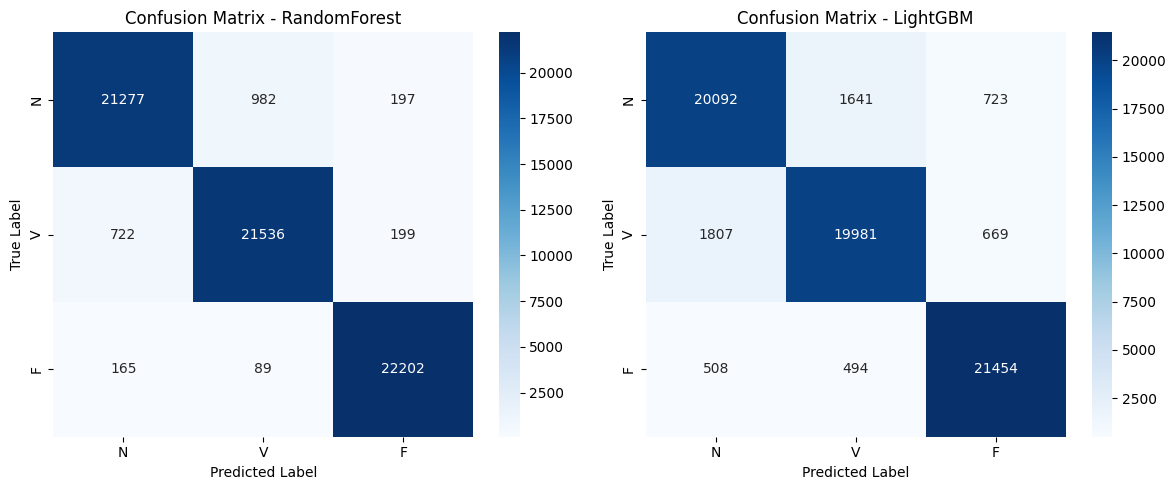

Classification results saved to classification_results_per_beat.csv


In [13]:
# 混淆矩阵可视化
fig, axes = plt.subplots(1, len(models), figsize=(6 * len(models), 5))
if len(models) == 1:
    axes = [axes]  # 保证可迭代
for i, (model_name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=label_names, yticklabels=label_names)
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
plt.tight_layout()
plt.show()

# 保存评估结果
results_df = pd.DataFrame({
    'Model': [name for name in results],
    'Accuracy': [results[name]['accuracy'] for name in results],
    'Precision': [results[name]['precision'] for name in results],
    'Recall': [results[name]['recall'] for name in results],
    'F1': [results[name]['f1'] for name in results]
})
results_df.to_csv(os.path.join(output_dir, "classification_results_per_beat.csv"), index=False)
print("Classification results saved to classification_results_per_beat.csv")